# Tarea : Imputación de datos

* Alberto Ramos Sánchez
* Entrega: 21/10/2020
* Asignatura : Ciencia de Datos
* Máster Universitario de Sistemas Inteligentes y Aplicaciones Numéricas en Ingeniería

# Contenido

* [Tarea : Imputación de datos](#Tarea-:-Imputación-de-datos)
	* [Introducción](#Introducción)
	* [*Importación de módulos*](#*Importación-de-módulos*)
	* [Carga del dataset](#Carga-del-dataset)
	* [Descripción del dataset](#Descripción-del-dataset)
	* [Implementación de los métodos de imputación](#Implementación-de-los-métodos-de-imputación)
		* [Método de imputación múltiple por ecuaciones encadenadas mediante regresión lineal](#Método-de-imputación-múltiple-por-ecuaciones-encadenadas-mediante-regresión-lineal)
		* [Método de imputación *Hot-Deck*](#Método-de-imputación-*Hot-Deck*)
			* [*Ilustración de ejemplo*](#*Ilustración-de-ejemplo*)
		* [Ejecución de los métodos y comparación](#Ejecución-de-los-métodos-y-comparación)
			* [Comparación de métodos mediante error cuadrático medio](#Comparación-de-métodos-mediante-error-cuadrático-medio)
				* [MICE](#MICE)
				* [Hot-Deck](#Hot-Deck)
	* [Conclusión](#Conclusión)


## Introducción

En este *notebook* se implementarán dos métodos de imputación de datos: imputación múltiple por ecuaciones encadenadas mediante regresión lineal e imputación *Hot-Deck*

Para aplicar estos métodos, se utilizará un *dataset* llamado *white wine quality*, el cual ha sido modificado para provocar que tenga valores perdidos en todas sus variables.

## *Importación de módulos*

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import linear_model, metrics
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm
import ipywidgets as wg
from IPython.display import Image

## Carga del dataset

In [2]:
missing_ds = pd.read_csv('datos\\winequality-white-missing.csv', sep=';', dtype={'quality':object})
original_ds = pd.read_csv('datos\\winequality-white.csv', sep=';', dtype={'quality':object})

## Descripción del dataset

Este dataset (extraído de <a id="ref-1" href="#cite-CorCer09">Cortez et al., 2009</a>) contiene la descripción de distintas muestras de la variedad de vino *vinho verde*, un vino blanco de Minho, región al noroeste de Portugal.

In [3]:
original_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   object 
dtypes: float64(11), object(1)
memory usage: 459.3+ KB


El dataset contiene 4898 muestras y 12 columnas, 11 de ellas numéricas y una categórica. Las columnas son las siguientes <a id="ref-2" href="#cite-DarAl">Alekseeva</a>:
- __Fixed Acidity (ácidos fijos):__ también conocidos como ácidos no volátiles.
- __Volatile Acidity (ácidos volátiles):__ cantidad de ácido acético que da el sabor avinagrado.
- __Citric Acid (Ácido cítrico):__ aporta "frescura" y sabor
- __Residual sugar (Azúcares residuales):__ azúcares sobrantes del proceso de fermentación del vino.
- __Chlorides (cloruros):__ sal.
- __Free sulfur dioxide (dióxido de azufre libre):__ dióxido de azufre que actúa como antioxidante.
- __Total sulfur dioxide (dióxido de azufre total):__ total de dióxido de azufre disuelto y libre en la muestra de vino.
- __Density (densidad):__ valores de densidad cercanos al del agua según la cantidad de alcohol y azúcar.
- __pH:__ ácidez o basicidad del vino en una escala entre 0 y 14
- __Sulphates (sulfato de potasio):__ aditivo que actúa como antioxidante. Puede influir en la cantidad de dióxido de azufre.
- __Alcohol:__ porcentaje de alcohol en el vino.
- __Quality:__ calidad del vino entre 0 - 10, basado en componentes subjetivos.

Dentro del dataset de datos perdidos podemos ver que los datos faltantes son de las columnas numéricas (las once primeras):

In [4]:
missing_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4400 non-null   float64
 1   volatile acidity      4431 non-null   float64
 2   citric acid           4411 non-null   float64
 3   residual sugar        4434 non-null   float64
 4   chlorides             4387 non-null   float64
 5   free sulfur dioxide   4398 non-null   float64
 6   total sulfur dioxide  4429 non-null   float64
 7   density               4413 non-null   float64
 8   pH                    4415 non-null   float64
 9   sulphates             4372 non-null   float64
 10  alcohol               4412 non-null   float64
 11  quality               4898 non-null   object 
dtypes: float64(11), object(1)
memory usage: 459.3+ KB


Utilizando la herramienta *pandas_profiling* podemos descubrir que hay un 9.1% de datos faltantes. Por cada columna son:
- __Fixed Acidity (ácidos fijos):__ 498 filas.
- __Volatile Acidity (ácidos volátiles):__ 467 filas.
- __Citric Acid (Ácido cítrico):__ 487 filas.
- __Residual sugar (Azúcares residuales):__ 464 filas.
- __Chlorides (cloruros):__ 511 filas.
- __Free sulfur dioxide (dióxido de azufre libre):__ 500 filas.
- __Total sulfur dioxide (dióxido de azufre total):__ 469 filas.
- __Density (densidad):__ 485 filas.
- __pH:__ 483 filas.
- __Sulphates (sulfatos):__ 526 filas.
- __Alcohol:__ 486 filas.
- __Quality :__ 0 filas.

In [5]:
informe = pandas_profiling.ProfileReport(missing_ds)
informe.to_file('informe.html')

In [5]:
missing_ds.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4400.000000,4431.000000,4411.000000,4434.000000,4387.000000,4398.000000,4429.000000,4413.000000,4415.000000,4372.000000,4412.000000
mean,6.849080,0.277857,0.334670,6.393223,0.046018,35.394839,137.756266,0.994038,3.188061,0.489879,10.518351
std,0.835875,0.100151,0.122274,5.086485,0.022396,17.092922,42.078770,0.003014,0.151680,0.114343,1.234730
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.740000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991740,3.080000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993800,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.850000,0.050000,46.000000,166.000000,0.996120,3.280000,0.550000,11.400000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [6]:
original_ds.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


## Implementación de los métodos de imputación

### Método de imputación múltiple por ecuaciones encadenadas mediante regresión lineal

Este método logra la imputación de datos combinando la imputación simple mediante algún valor estadístico (media, mediana, ...) con la imputación mediante regresión. Al aplicar este método asumimos que los datos fueron perdidos de forma aleatoria.

El algoritmo de este método consiste en:
 1. Realizar una imputación simple de las variables perdidas utilizando media, mediana, etc.
 2. Seleccionar una variable $x_i$ con valores perdidos y volver a cambiar los valores imputados por los perdidos.
 3. Realizar regresión usando como variable de respuesta $x_i$ y como variables predictoras el resto $x_{i\not=j}$
 4. Los valores perdidos en $x_{i}$ se sustituyen por las estimaciones obtenidas en el paso 3.
 5. Repetimos los pasos 2,3 y 4 por cada variable con valores perdidos un número de ciclos determinado.
 
La implementación de este método de imputación se realiza en el método *mice*.

Esta imputación solo puede aplicarse a valores numéricos, por lo que en (1) seleccionamos el nombre de las columnas cuyo tipo de dato son números (todas menos *quality*). Posteriormente —en (2)—, reservamos la posición en la que se encuentran los valores perdidos para, seguidamente, —en (3)— sustituirlos por la mediana.

Finalmente, aplicamos sustitución por regresión lineal a cada una de las columnas, utilizando como entrada las demás columnas (solamente seleccionamos las numéricas) y como salida la columna a la que queremos imputar los valores. Este procedimiento se realiza columna a columna, un número determinado de épocas —en (4)—.

In [7]:
def mice(df, epochs):
    
    # (1) obtenemos nombre de columnas numéricas, que son a las que se le aplica MICE 
    cols = df._get_numeric_data().columns
    
    # (2) reservamos posición de valores nulos
    missing_loc = df.isnull()
    
    # (3) Imputamos valores de la mediana en todas las columnas
    for c in cols:
        missing_pos = missing_loc[c]
        
        median_val = df.loc[~missing_pos, c].median()
        
        df.loc[missing_pos, c] = median_val        
    
    # (4) aplicamos sustitución por regresion lineal a cada columna un número de épocas
    # trange muestra barra de progreso en consola
    for _ in trange(epochs, desc="Progress", unit="epoch"):
        
        for c in cols:
            
            missing_pos = missing_loc[c]
            
            X_missing = df._get_numeric_data().loc[missing_pos].drop(c, axis=1) \
                                           .values
            X = df._get_numeric_data().loc[~missing_pos].drop(c, axis=1) \
                                    .values
            y = df._get_numeric_data().loc[~missing_pos, c].values
            
            # (5) Regresion lineal
            
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X, y)
            
            column_pred = regression_model.predict(X_missing)
            
            df.loc[missing_pos, c] = column_pred


### Método de imputación *Hot-Deck*

Este método logra la imputación de valores perdidos sustituyéndolos por el valor que posee la muestra más cercana según los demás atributos. Este método se diferencia del anterior en que no es necesario estimar valores.

La implementación de este método se encuentra en el método *hot-deck*.

Este método de imputación es aplicado únicamente a los valores numéricos, por lo que recorremos columna a columna entre las numéricas —en (3)— buscándo para cada fila con dato perdido el valor de la fila que tiene los valores de las demás columnas más cercana. 

Es posible que en una misma fila existan varias columnas con valores perdidos. Por lo tanto, para realizar la búsqueda del valor más cercano, primeramente, seleccionamos las columnas que no son nulas en la fila a la que vamos a imputar. Posteriormente, seleccionamos entre las filas que no tienen datos perdidos para la columna en la que vamos a imputar aquellas que tengan todos los valores no nulos de las columnas seleccionadas anteriormente. De este modo, nos aseguramos que las medidas de distancias no se realicen con valores nulos. (Código en (7), (8), y (9))

Finalmente, calculamos la distancia entre los valores de la fila en que vamos a imputar y las que si tienen valores, seleccionando la más cercana, e imputando el valor.

#### *Ilustración de ejemplo*

In [8]:
def image(x):
    return Image(filename='./images/ejemplo_hotdeck/i{}.png'.format(x))

print("Pasar diapositiva: ", end="")
wg.interact(image, x=wg.IntSlider(min=1,max=5,step=1));



Pasar diapositiva: 

interactive(children=(IntSlider(value=1, description='x', max=5, min=1), Output()), _dom_classes=('widget-inte…

In [9]:
def hot_deck(df):
    
    # (1) columnas numéricas
    cols = df._get_numeric_data().columns
    
    # (2) posiciones perdidas
    missing_loc = df.isnull()
    
    # (3) recorremos columnas numéricas
    for c in tqdm(cols, desc="Progress"):
        
        # (4) filas con datos perdidos : a las que se le imputará datos
        missing_data = df.loc[missing_loc[c]]._get_numeric_data()
        # (5) filas con datos no perdidos : donde se buscara el más cercano
        no_missing_data = df.loc[(~missing_loc)[c]]._get_numeric_data()
        
        # (6) Recorremos fila a fila
        for index, row in missing_data.iterrows():
            """
            index == nº fila a imputar
            row == valores de la fila a imputar
            """
            
            # (7) seleccionamos las columnas sin valores no nulos
            # search info contiene los valores utilizados para encontrar la fila más cercana
            search_info = row[row.notnull()]
            search_cols = search_info.index
            
            # (8) seleccionamos las filas no nulas con valores no nulos en las columnas que indica search_cols
            search_rows = no_missing_data.loc[:, search_cols].notnull()
            search_rows = search_rows[search_rows == True].dropna().index
            
            # (9) datos donde se buscara el más cercano
            search_data = no_missing_data.loc[search_rows, search_cols]
            
            # (10) buscamos el más cercano según distancia euclídea sin raíz cuadrada
            dist = ((search_data - search_info)**2).sum(axis=1)
            smallest_dist_index = dist.index[dist.values.argmin()]
            imputation_value = df.loc[smallest_dist_index, c]
            
            # (11) imputamos el valor
            df.loc[index, c] = imputation_value
    

### Ejecución de los métodos y comparación

A continuación ejecutamos los dos métodos propuestos. La comparación de su eficacia se realizará mediante el cálculo del error medio cuadrático con los datos originales (sin valores perdidos).

In [10]:
mice_result = missing_ds.copy()
mice(mice_result, 100)

In [11]:
mice_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   object 
dtypes: float64(11), object(1)
memory usage: 459.3+ KB


In [12]:
hotdeck_result = missing_ds.copy()
hot_deck(hotdeck_result)

In [13]:
hotdeck_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   object 
dtypes: float64(11), object(1)
memory usage: 459.3+ KB


#### Comparación de métodos mediante error cuadrático medio

##### MICE

Error global

In [14]:
msc = metrics.mean_squared_error(mice_result, original_ds)
msc

9.652350161628014

Error por atributos

<BarContainer object of 11 artists>

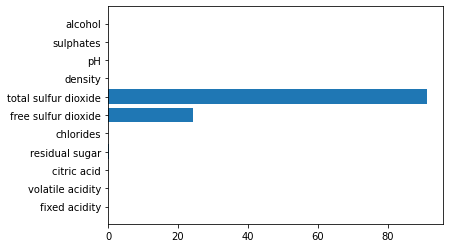

In [15]:
errores = []
labels = []
for c in mice_result._get_numeric_data().columns:
    msc = metrics.mean_squared_error(mice_result._get_numeric_data().loc[:, c], original_ds._get_numeric_data().loc[:,c])
    errores.append(msc)
    labels.append(c)

plt.barh(labels, errores)

##### Hot-Deck

In [16]:
msc = metrics.mean_squared_error(hotdeck_result, original_ds)
msc

13.583656830963763

<BarContainer object of 11 artists>

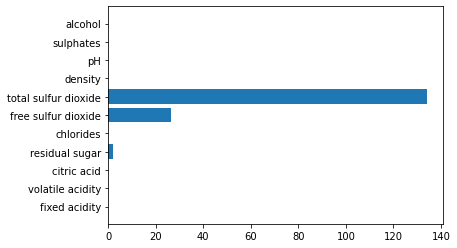

In [17]:
errores = []
labels = []
for c in hotdeck_result._get_numeric_data().columns:
    msc = metrics.mean_squared_error(hotdeck_result._get_numeric_data().loc[:, c], original_ds._get_numeric_data().loc[:,c])
    errores.append(msc)
    labels.append(c)

plt.barh(labels, errores)

## Conclusión

Hemos comprobado como el método *MICE* es más efectivo para imputar valores. Este resultado podríamos esperarlo porque el método MICE tiene en cuenta la relación entre las distintas muestras y atributos: a través de la imputación de la mediana se acerca cada valor perdido al valor medio de ese atributo, y a través de la regresión se estima el valor según la relación que tienen otros atributos. En cambio, *hot-deck* simplemente sustituye el valor más cercano según otros atributos, sin tener en cuenta si estos atributos afectan al que estamos imputando.

***

<!--bibtex

    @article{CorCer09,
            Author = {P. Cortez and A. Cerdeira and F. Almeida and T. Matos and J. Reis},
            Journal = {Decision Support Systems},
            Number = {4},
            Pages = {547-553},
            Title = {{Modeling wine preferences by data mining from physicochemical properties}},
            Volume = {47},
            Year = {1998},
            Doi = {10.1016/j.dss.2009.05.016},
            Url = {https://doi.org/10.1016/j.dss.2009.05.016}
            
    }

    @misc {DarAl
        Author = {Daria Alekseeva},
        title = {Red and White Wine Quality},
        howpublished = {\url{https://rstudio-pubs-static.s3.amazonaws.com/57835_c4ace81da9dc45438ad0c286bcbb4224.html}},
        note = {Accessed: 2020-13-10}
    }

-->

***

# References

<a id="cite-CorCer09"/><sup><a href=#ref-1>[^]</a></sup>P. Cortez and A. Cerdeira and F. Almeida and T. Matos and J. Reis. 1998. _Modeling wine preferences by data mining from physicochemical properties_. DOI : https://doi.org/10.1016/j.dss.2009.05.016

<a id="cite-DarAl"/><sup><a href=#ref-2>[^]</a></sup>D. Alekseeva. _Red and White Wine Quality_ <a href=https://rstudio-pubs-static.s3.amazonaws.com/57835_c4ace81da9dc45438ad0c286bcbb4224.html>https://rstudio-pubs-static.s3.amazonaws.com/57835_c4ace81da9dc45438ad0c286bcbb4224.html</a> __Accessed: 2020-13-10__